In [8]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [9]:
import torch
import matplotlib.pyplot as plt

torch.manual_seed(1)

batch_size = 32
class_map = {
    'airplane': 0,
    'automobile': 1,
    'bird': 2,
    'cat': 3,
    'deer': 4,
    'dog': 5,
    'frog': 6,
    'horse': 7,
    'ship': 8,
    'truck': 9
}
show_summary = True
show_dataset_analyze = True

In [10]:
# Load Network and Print Summary
from DeepLib.model import CifarNet
from DeepLib.utils import get_device, print_summary

# Check GPU availability
use_cuda, device = get_device()

In [11]:
from DeepLib.dataset import get_loader
from DeepLib.transform import get_a_train_transform, get_a_test_transform

train_loader, test_loader = get_loader('CIFAR10',get_a_train_transform(), get_a_test_transform(), batch_size=batch_size, use_cuda=use_cuda)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001CE0D4448B0>
Traceback (most recent cal

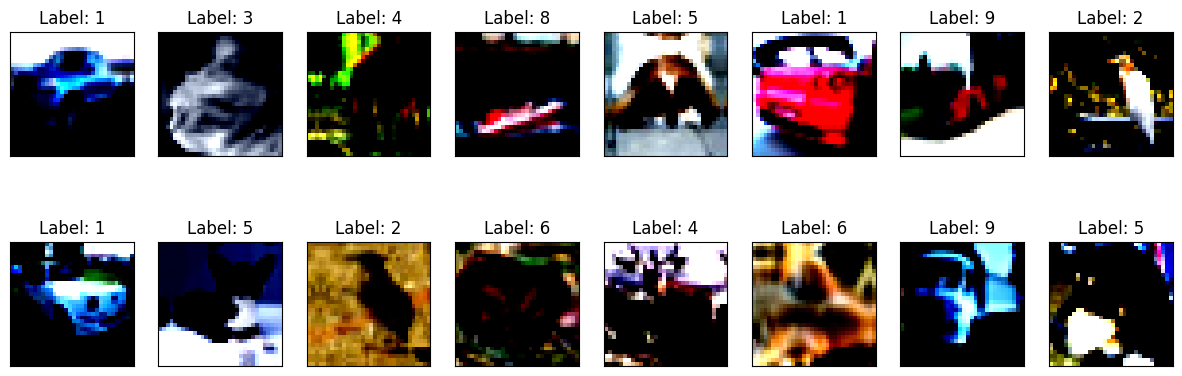

In [15]:
# Calculate Class Scale
from DeepLib.visualize import print_class_scale, print_samples
if show_dataset_analyze:
    # print_class_scale(train_loader, class_map)
    print_samples(train_loader,class_map)# 

In [13]:




if show_summary:
    model = CifarNet(norm='bn',base_channels=14).to(device)
    print_summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 14, 32, 32]             392
       BatchNorm2d-2           [-1, 14, 32, 32]              28
            Conv2d-3           [-1, 14, 32, 32]           1,778
       BatchNorm2d-4           [-1, 14, 32, 32]              28
            Conv2d-5           [-1, 14, 32, 32]             210
         MaxPool2d-6           [-1, 14, 16, 16]               0
           Dropout-7           [-1, 14, 16, 16]               0
            Conv2d-8           [-1, 28, 16, 16]           3,556
       BatchNorm2d-9           [-1, 28, 16, 16]              56
           Conv2d-10           [-1, 28, 16, 16]           7,084
      BatchNorm2d-11           [-1, 28, 16, 16]              56
           Conv2d-12           [-1, 28, 16, 16]           7,084
      BatchNorm2d-13           [-1, 28, 16, 16]              56
           Conv2d-14           [-1, 28,

In [14]:
import time
import math

from DeepLib.backpropagation import train, test, get_sgd_optimizer
from DeepLib.utils import initialize_weights
from DeepLib.scheduler import one_cycle_lr_pt, one_cycle_lr_custom
from DeepLib.training import Training

# Train Params
epochs = 15
lr = 0.05
max_lr = 0.1
steps_per_epoch = len(train_loader)
dropout = True
momentum = 0.9
weight_decay = 0

print("Using Device:", device)
print("Epochs:", epochs)
print("Lr:", lr)
print("Max Lr:", max_lr)
print("Batch Size:", batch_size)
print("Dropout:", dropout)
print("\n")

# bnmodel = CifarNet(norm='bn',base_channels=12).apply(initialize_weights).to(device)
bnmodel = CifarNet(norm='bn',base_channels=12).apply(initialize_weights).to(device)
optimizer = get_sgd_optimizer(bnmodel, lr=lr)

# Pytorch one cycle scheduler
pytorch_scheduler = one_cycle_lr_pt(
    optimizer, 
    lr=lr, 
    max_lr=max_lr, 
    steps_per_epoch=steps_per_epoch, 
    epochs=epochs, 
    anneal_strategy='linear'
)

# One cycle schedule with a custom function
custom_scheduler = one_cycle_lr_custom(
    optimizer, 
    lr=lr, 
    max_lr=max_lr, 
    steps_per_epoch=steps_per_epoch, 
    epochs=epochs, 
    anneal_strategy='linear'
)

trainer = Training(
    model,
    optimizer,
    custom_scheduler,
    train(),
    test,
    train_loader,
    test_loader,
    lr,
    epochs,
    device,
    dropout
)

trainer.run()

Using Device: cuda
Epochs: 15
Lr: 0.05
Max Lr: 0.1
Batch Size: 32
Dropout: True


| Epoch | LR       | Time    | TrainLoss | TrainCorrect | TrainAcc | ValLoss  | ValCorrect | ValAcc |
|     1 | 0.050000 | 00m 39s | 2.339598  |         4660 | 9.32   % | 2.344654 |        929 | 9.29 % |
|     2 | 0.075000 | 00m 38s | 2.339423  |         4708 | 9.42   % | 2.345287 |        940 | 9.4  % |


KeyboardInterrupt: 

In [ ]:
# Load Network and Print Summary
from DeepLib.model import CifarNet
from DeepLib.utils import get_device, print_summary

# Check GPU availability
use_cuda, device = get_device()

if show_summary:
    model = CifarNet(norm='ln',base_channels=14).to(device)
    print_summary(model, input_size=(3, 32, 32))

In [ ]:
import time
import math

from DeepLib.backpropagation import train, test, get_sgd_optimizer
from DeepLib.utils import initialize_weights
from DeepLib.scheduler import one_cycle_lr_pt, one_cycle_lr_custom
from DeepLib.training import Training

# Train Params
epochs = 20
lr = 0.05
max_lr = 0.1
steps_per_epoch = len(train_loader)
dropout = True
momentum = 0.9
weight_decay = 0

print("Using Device:", device)
print("Epochs:", epochs)
print("Lr:", lr)
print("Max Lr:", max_lr)
print("Batch Size:", batch_size)
print("Dropout:", dropout)
print("\n")

lnmodel = CifarNet(norm='ln').apply(initialize_weights).to(device)
optimizer = get_sgd_optimizer(lnmodel, lr=lr)

# Pytorch one cycle scheduler
pytorch_scheduler = one_cycle_lr_pt(
    optimizer, 
    lr=lr, 
    max_lr=max_lr, 
    steps_per_epoch=steps_per_epoch, 
    epochs=epochs, 
    anneal_strategy='linear'
)

# One cycle schedule with a custom function
custom_scheduler = one_cycle_lr_custom(
    optimizer, 
    lr=lr, 
    max_lr=max_lr, 
    steps_per_epoch=steps_per_epoch, 
    epochs=epochs, 
    anneal_strategy='linear'
)

trainer = Training(
    model,
    optimizer,
    custom_scheduler,
    train(),
    test,
    train_loader,
    test_loader,
    lr,
    epochs,
    device,
    dropout
)

trainer.run()

In [ ]:
# Load Network and Print Summary
from DeepLib.model import CifarNet
from DeepLib.utils import get_device, print_summary

# Check GPU availability
use_cuda, device = get_device()

if show_summary:
    model = CifarNet(norm='gn',base_channels=15).to(device)
    print_summary(model, input_size=(3, 32, 32))

In [ ]:
import time
import math

from DeepLib.backpropagation import train, test, get_sgd_optimizer
from DeepLib.utils import initialize_weights
from DeepLib.scheduler import one_cycle_lr_pt, one_cycle_lr_custom
from DeepLib.training import Training

# Train Params
epochs = 20
lr = 0.05
max_lr = 0.1
steps_per_epoch = len(train_loader)
dropout = True
momentum = 0.9
weight_decay = 0

print("Using Device:", device)
print("Epochs:", epochs)
print("Lr:", lr)
print("Max Lr:", max_lr)
print("Batch Size:", batch_size)
print("Dropout:", dropout)
print("\n")

gnmodel = CifarNet(norm='gn',base_channels=15).apply(initialize_weights).to(device)
optimizer = get_sgd_optimizer(gnmodel, lr=lr)

# Pytorch one cycle scheduler
pytorch_scheduler = one_cycle_lr_pt(
    optimizer, 
    lr=lr, 
    max_lr=max_lr, 
    steps_per_epoch=steps_per_epoch, 
    epochs=epochs, 
    anneal_strategy='linear'
)

# One cycle schedule with a custom function
custom_scheduler = one_cycle_lr_custom(
    optimizer, 
    lr=lr, 
    max_lr=max_lr, 
    steps_per_epoch=steps_per_epoch, 
    epochs=epochs, 
    anneal_strategy='linear'
)

trainer = Training(
    model,
    optimizer,
    custom_scheduler,
    train(),
    test,
    train_loader,
    test_loader,
    lr,
    epochs,
    device,
    dropout
)

trainer.run()